# VAE for MNIST clustering and generation

The goal of this notebook is to explore some recent works dealing with variational auto-encoder (VAE).

We will use MNIST dataset and a basic VAE architecture. 

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size)) 
    except:
        out, _, _ = model(x.view(-1, image_size)) 
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

def plot_conditional_generation(model, n=8, fix_number=None):
    with torch.no_grad():
        matrix = np.zeros((n,n_classes))
        matrix[:,0] = 1

        if fix_number is None:
            final = matrix[:]
            for i in range(1,n_classes):
                final = np.vstack((final,np.roll(matrix,i)))
            z = torch.randn(8*n_classes, z_dim).to(device)
            y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)
        else:
            z = torch.randn(n, z_dim).to(device)
            y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
batch_size = 128

data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Variational Autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instead maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$.
  
The variational posterior $q_{\phi}(z|x)$ is also called the **encoder** and the generative model $p_{\theta}(x|z)$, the **decoder** or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), I)$ the term $\log p_\theta(x|z)$ reduces to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0, I)$.

Variational Autoencoders were introduced by [Kingma and Welling (2013)](https://arxiv.org/abs/1312.6114), see also [(Doersch, 2016)](https://arxiv.org/abs/1606.05908) for a tutorial.

There are various examples of VAE in PyTorch available [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65). The code below is taken from this last source.

![A variational autoencoder.](vae.png)

In [4]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take Binary Cross-Entropy. The code below is still from the PyTorch tutorial (with minor modifications to avoid warnings!).

In [5]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # We compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))

Epoch[1/15], Step [10/469], Reconst Loss: 268.0755, KL Div: 31.7235
Epoch[1/15], Step [20/469], Reconst Loss: 233.0316, KL Div: 7.9228
Epoch[1/15], Step [30/469], Reconst Loss: 214.5267, KL Div: 9.4640
Epoch[1/15], Step [40/469], Reconst Loss: 205.9449, KL Div: 5.5504
Epoch[1/15], Step [50/469], Reconst Loss: 202.9502, KL Div: 5.7390
Epoch[1/15], Step [60/469], Reconst Loss: 201.4528, KL Div: 6.0375
Epoch[1/15], Step [70/469], Reconst Loss: 193.9385, KL Div: 6.2759
Epoch[1/15], Step [80/469], Reconst Loss: 193.7101, KL Div: 7.6853
Epoch[1/15], Step [90/469], Reconst Loss: 182.2374, KL Div: 9.1139
Epoch[1/15], Step [100/469], Reconst Loss: 185.1697, KL Div: 9.7476
Epoch[1/15], Step [110/469], Reconst Loss: 172.6789, KL Div: 10.9994
Epoch[1/15], Step [120/469], Reconst Loss: 171.5853, KL Div: 12.0920
Epoch[1/15], Step [130/469], Reconst Loss: 165.3242, KL Div: 14.2735
Epoch[1/15], Step [140/469], Reconst Loss: 147.4088, KL Div: 13.8020
Epoch[1/15], Step [150/469], Reconst Loss: 156.2430,

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

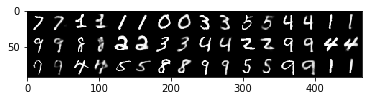

In [6]:
plot_reconstruction(model)

Let's see now how our network generates new samples.

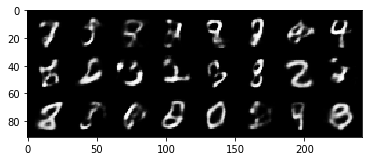

In [7]:
plot_generation(model)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. In the rest of this notebook, we explore ways to generates zeroes, ones, twos and so on. As a by-product, we show how our VAE will allow us to do clustering.

The main idea is to build what we call a Gumbel VAE as described below.

# Gumbel VAE

We wiol now implement a VAE where we add a categorical variable $c\in \{0,\dots 9\}$ so that our latent variable model is $p(c,z,x) = p(c)p(z)p_{\theta}(x|,c,z)$ and our variational posterior is $q_{\phi}(c|x)q_{\phi}(z|x)$ as described in this NeurIPS paper: [(Dupont, 2018)](https://arxiv.org/abs/1804.00104).

The idea is to incorporate a categorical variable in your latent space. We hope that this categorical variable will encode the class of the digit, so that our network can use it for a better reconstruction. Moreover, if things work as planned, we will then be able to generate digits conditionally to the class, i.e. we can choose the class thanks to the latent categorical variable $c$ and then generate digits from this class.

As noticed above, in order to sample random variables while still being able to use backpropagation, we need to use the reparameterization trick which is easy for Gaussian random variables. For categorical random variables, the reparameterization trick is explained in [(Jang et al., 2016)](https://arxiv.org/abs/1611.01144). This is implemented in PyTorch thanks to [F.gumbel_softmax](https://pytorch.org/docs/stable/nn.html?highlight=gumbel_softmax#torch.nn.functional.gumbel_softmax).

In [8]:
n_classes = 10

class VAE_Gumbel(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Gumbel, self).__init__()
        
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(h_dim, n_classes)
        self.fc5 = nn.Linear(z_dim+n_classes, h_dim)
        self.fc6 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = F.relu(self.fc2(h))
        log_var = F.relu(self.fc3(h))
        classes = F.softmax(self.fc4(h), dim=1)  
        return mu, log_var, classes
        
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        z = torch.cat([z, y_onehot], dim=-1).type(torch.float32)
        h = F.relu(self.fc5(z))
        return torch.sigmoid(self.fc6(h))
    
    def forward(self, x):
        mu, log_var, classes = self.encode(x)
        z = self.reparameterize(mu, log_var)
        y_onehot = F.gumbel_softmax(classes)
        x_reconst = self.decode(z, y_onehot)
        return x_reconst, mu, log_var, classes
        

model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

We need to modify the loss to take into account the categorical random variable with an uniform prior on $\{0,\dots 9\}$, see Appendix A.2 in [(Dupont, 2018)](https://arxiv.org/abs/1804.00104)

In [9]:
def train_G(model, data_loader=data_loader,num_epochs=num_epochs, beta = 1., verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, classes = model(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            H_cat = torch.mean(torch.sum(classes * torch.log(1e-20 + classes), dim=1), dim=0) + torch.Tensor([np.log(n_classes)])

            # Backprop and optimize
            loss = reconst_loss + kl_div + H_cat
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i) % 10 == 0:
                    
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div.item()/batch_size, H_cat.item()/batch_size))

In [10]:
train_G(model_G,num_epochs=10,verbose=True)

Epoch[1/10], Step [1/469], Reconst Loss: 546.4901, KL Div: 0.0594, Entropy: 0.0000
Epoch[1/10], Step [11/469], Reconst Loss: 293.2685, KL Div: 28.9854, Entropy: 0.0030
Epoch[1/10], Step [21/469], Reconst Loss: 237.7176, KL Div: 11.2970, Entropy: 0.0038
Epoch[1/10], Step [31/469], Reconst Loss: 216.7298, KL Div: 8.6877, Entropy: 0.0034
Epoch[1/10], Step [41/469], Reconst Loss: 206.7947, KL Div: 5.9059, Entropy: 0.0032
Epoch[1/10], Step [51/469], Reconst Loss: 211.7386, KL Div: 4.6629, Entropy: 0.0030
Epoch[1/10], Step [61/469], Reconst Loss: 199.0124, KL Div: 4.7297, Entropy: 0.0031
Epoch[1/10], Step [71/469], Reconst Loss: 206.9368, KL Div: 5.2481, Entropy: 0.0032
Epoch[1/10], Step [81/469], Reconst Loss: 203.4962, KL Div: 5.3460, Entropy: 0.0038
Epoch[1/10], Step [91/469], Reconst Loss: 195.1020, KL Div: 5.7136, Entropy: 0.0040
Epoch[1/10], Step [101/469], Reconst Loss: 192.1077, KL Div: 7.4200, Entropy: 0.0052
Epoch[1/10], Step [111/469], Reconst Loss: 182.2886, KL Div: 6.9065, Entro

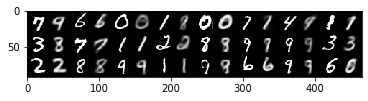

In [11]:
plot_reconstruction(model_G)

This was for reconstruction, but we care more about generation. For each category, we are generating 8 samples thanks to the `plot_conditional_generation()` function.

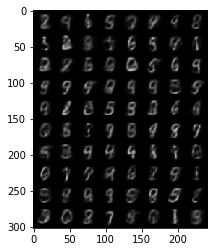

In [12]:
plot_conditional_generation(model_G, n=8)

It does not look like our original idea is working...

What is happening is that our network is not using the categorical variable. We can track the [normalized mutual information](https://en.wikipedia.org/wiki/Mutual_information#Normalized_variants) (see [this method in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html)) between the true labels and the labels predicted by our network (just by taking the category with maximal probability). 
We will Change our training loop to return the normalized mutual information (NMI) for each epoch. Plot the curve to check that the NMI is actually decreasing.

This problem is explained in [(Burgess et al., 2018)](https://arxiv.org/abs/1804.03599) and a solution is proposed in Section 5.

In order to force our network to use the categorical variable, we will change the loss according to [(Dupont, 2018)](https://arxiv.org/abs/1804.00104), Section 3 Equation (7).

Implement this change in the training loop and plot the new NMI curve. For $\beta = 20, C_z=100, C_c=100$, you should see that NMI increases.

In [13]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

In [14]:
def train_G_modified_loss(model, data_loader,num_epochs, beta , C_z_fin, C_c_fin, verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, classes = model(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = - beta * 0.5 * torch.abs(torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) - C_z_fin)
            H_cat = beta * torch.abs(torch.sum(classes * torch.log(1e-20 + classes/(1.0/n_classes))) - C_c_fin)

            # Backprop and optimize
            loss = reconst_loss + kl_div + H_cat
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div.item()/batch_size, H_cat.item()/batch_size))

In [15]:
# Hyper-parameters
num_epochs = 10
learning_rate = 1e-3
beta = 20
C_z_fin=200
C_c_fin=200

model_G = VAE_Gumbel(z_dim = z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

train_G_modified_loss(model_G, data_loader, num_epochs=num_epochs, beta=beta, C_z_fin=C_z_fin, C_c_fin=C_c_fin)

Epoch[1/10], Step [10/469], Reconst Loss: 290.2367, KL Div: -2075.3970, Entropy: 13.9782
Epoch[1/10], Step [20/469], Reconst Loss: 1507.5693, KL Div: -1489149.3750, Entropy: 2.2473
Epoch[1/10], Step [30/469], Reconst Loss: 8581.1992, KL Div: -8578531328000.0000, Entropy: 1.9335
Epoch[1/10], Step [40/469], Reconst Loss: 11250.6035, KL Div: -1682952601731072.0000, Entropy: 1.4900
Epoch[1/10], Step [50/469], Reconst Loss: 11549.2354, KL Div: -55072470353439621120.0000, Entropy: 0.9694
Epoch[1/10], Step [60/469], Reconst Loss: 11192.3154, KL Div: -26535864278212744839168.0000, Entropy: 0.1832
Epoch[1/10], Step [70/469], Reconst Loss: 10719.5596, KL Div: -1213790880637386752.0000, Entropy: 0.1279
Epoch[1/10], Step [80/469], Reconst Loss: 11215.5723, KL Div: -52750939512320819200.0000, Entropy: 0.3487
Epoch[1/10], Step [90/469], Reconst Loss: 11182.8311, KL Div: -994767752067547136.0000, Entropy: 0.0232
Epoch[1/10], Step [100/469], Reconst Loss: 10446.6865, KL Div: -4606613971288457216.0000,

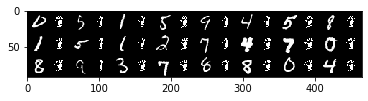

In [16]:
plot_reconstruction(model_G)

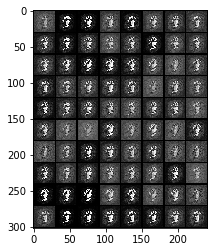

In [17]:
plot_conditional_generation(model_G, fix_number=None)

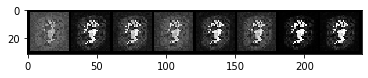

In [18]:
plot_conditional_generation(model_G, fix_number=0)